Track ML - Particle Tracking Challenge

In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

In [166]:
# To get an idea what we're up against, let's start by peeking at our
# dataset ~ https://www.kaggle.com/c/trackml-particle-identification/data
# 
# Since the set is somewhat large (~200 GB), I'll start by looking at a
# single event file chosen randomly from the 8,850 training events available:

file = 'event000001004-hits.csv'
data = pd.read_csv(file)

In [395]:
# This file contains hits recorded in the particle detector, with
# particles potentially registering multiple hits as they maneuver
# their way outwards from the beam center.

# Note that we have other files that are meant to help us develop
# and train our algorithm, but these will not be available in the
# testing phase.  Finally takin' that peek at our data...

display(data.head())
display(data.describe())

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-69.6910,-9.823170,-1502.5,7,2,1
1,2,-78.1122,-13.946600,-1502.5,7,2,1
2,3,-48.0897,-8.273580,-1502.5,7,2,1
3,4,-58.0116,-9.702010,-1502.5,7,2,1
4,5,-95.8917,-0.249342,-1502.5,7,2,1


,hit_id,x,y,z,volume_id,layer_id,module_id
count,138568.000000,138568.000000,138568.000000,138568.000000,138568.000000,138568.000000,138568.000000
mean,69284.500000,-1.946073,2.047193,22.399250,10.891086,5.902272,368.306651
std,40001.280388,301.785405,301.159530,1063.901358,3.343136,3.401814,524.521030
min,1.000000,-1025.170000,-1024.470000,-2955.500000,7.000000,2.000000,1.000000
25%,34642.750000,-99.377875,-93.752850,-602.500000,8.000000,4.000000,60.000000
50%,69284.500000,-0.562639,0.510325,12.550050,9.000000,6.000000,119.000000
75%,103926.250000,97.630925,97.109175,697.500000,13.000000,8.000000,481.000000
max,138568.000000,1025.280000,1025.250000,2955.500000,18.000000,14.000000,3192.000000


In [ ]:
# Our input consists of the position coordinate of every hit registered by the detector.

# We can already make a few observqtions about our event: particle
# hits are approximately distributed about the center [(x,y, z) = (0, 0, 0)]
# in a seemingly symmetric fashion.  The system appears to also be
# rotationally invariant in x,y, which makes sense given the collider tube's
# cylindrical-ish geometry.

# We're also given some information on the volume_id (etc) for each hit.
# We'll ignore this for the time being in favor of taking a quick and dirty look at 
# the spatial distribution of hits in an event.

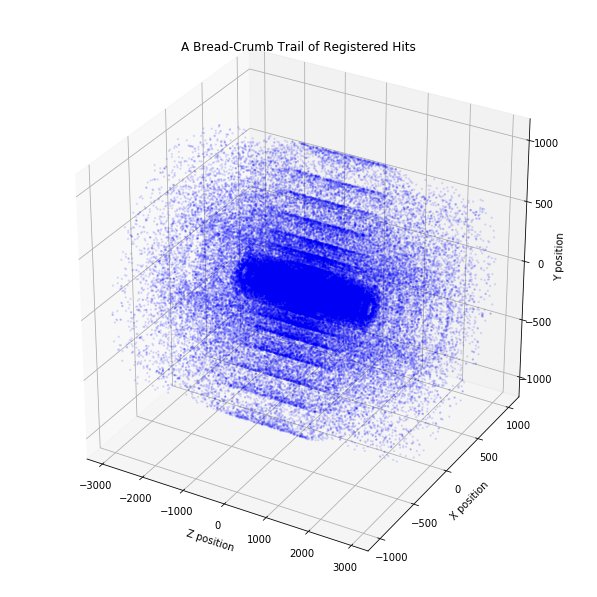

In [408]:
# Dropping the extra columnns, I chart below the 3D location of all detector hits
# included in this event.  

# Though unimportant individually, these hits collectively form
# an intellectual bread crumb trail, encoding and subtly guiding us toward the secrets hiding
# in the exotic interaction from which they came.

hitxyz = data.drop(['volume_id', 'layer_id', 'module_id'], axis=1)

x_coords = np.array(list(hitxyz['x']))
y_coords = np.array(list(hitxyz['y']))
z_coords = np.array(list(hitxyz['z']))

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(z_coords, x_coords, y_coords, s=2, color='blue', alpha=0.09)

ax.set_title('A Bread-Crumb Trail of Registered Hits')
ax.set_xlabel('Z position')
ax.set_ylabel('X position')
ax.set_zlabel('Y position')

plt.show()

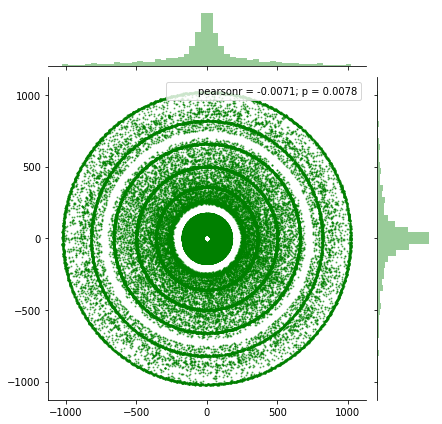

In [463]:
# The above is a visual record of the charged byproducts of our original event; as they pour out from the center and 
# smack into the detector, we're left with a complete mess of information to sift through.  Learning anything at all 
# from this explosion-like experiment will likely require spectacular precision in our analysis--every single speck 
# in the image must be evaluated and categorized, each assigned to a unique particle track.

# We quickly examine a two-dimensional cross section of the event.  Using seaborn's jointplot, we can easily
# incorporate x and y's marginalized univariate distributions into the display:

hitxyz = data.drop(['volume_id', 'layer_id', 'module_id'], axis=1)

x_coords = np.array(list(hitxyz['x']))
y_coords = np.array(list(hitxyz['y']))
z_coords = np.array(list(hitxyz['z']))

sns.jointplot(x_coords, y_coords, s=1, alpha=0.5, color='green')
plt.show()

# We see that the polar symmetry we suspected before is quite robust (though deviations will exist).
# Pearson's R also gives us confidence that x and y are independent from one another.

In [426]:
# If we liked, we could try to solve this problem at this point without any extra information.  Such an approach would
# necessarily rely on the clustering methods of unsupervised machine learning--we have no idea which dots
# actually belong to which tracks or even how we should generate the tracks in the first place, but the hope
# is that it could be inferred from the structure of the data.  Though we attempt this later with PCA, k-means
# clustering, and DB-Scan, these methods generally underperform compared to their supervised learning counterparts;
# they do not utilize the information that could be gained from labeled data.  Despite their pitfalls, partially
# unsupervised methods will be useful to use later in the analysis.

In [171]:
# Before designing or implementing an algorithm, though, we should first explore the labeled training data in the "event-truth" files
# to see if we can uncover any naturally present patterns in our 'solution key'.

file2 = 'event000001004-truth.csv'
truths = pd.read_csv(file2)
truths.head()
truth_short = pd.DataFrame(truths, columns=['hit_id', 'particle_id'])

In [409]:
# The "event-truth" file keeps track of every hit (labeled by its ID), its specific weight within its parent
# particle track, and the label of the particle to which its track belongs.  These data are the solutions
# we are tasked with generating.  

# Notice here that number of unique particle IDs is arbitrary; we will be unable to specify the number
# of categorical classes our model will need a priori..

# Examining all hit IDs associated with a randomly chosen particle ID:

truth_table.loc[324272917066022912]

,hit_id,weight
particle_id,,
324272917066022912,2,0.000007
324272917066022912,68,0.000006
324272917066022912,1659,0.000006
324272917066022912,1724,0.000004
324272917066022912,3648,0.000004
324272917066022912,3689,0.000004
324272917066022912,6076,0.000004
324272917066022912,6159,0.000004
324272917066022912,8900,0.000004


In [393]:
# Since we want to associate each hit and track with a  particle ID, it'll be useful
# to group our hits by their parent particle ID.

truth_short.groupby('particle_id').count().head(10);

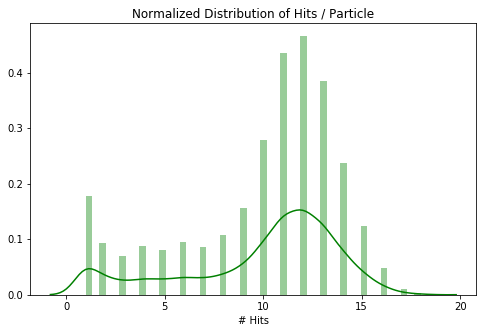

In [411]:
# If we want to know how many points/hits the average track should include,
# we can quickly get an idea from plotting the "event trutH" data for this event.

plt.figure(figsize=(8,5))

sns.distplot(truth_short[truth_short.particle_id > 0].groupby('particle_id').count().hit_id, bins=50, color='green')
plt.title('Normalized Distribution of Hits / Particle')
plt.xlabel('# Hits', fontsize='medium')

plt.show()

In [201]:
# Now taking the group of "hits" in the hit data corresponding to our
# chosen example particle, 4504218102661120.

Example_hits = list(truth_short.query('particle_id == \
                  4504218102661120').hit_id)

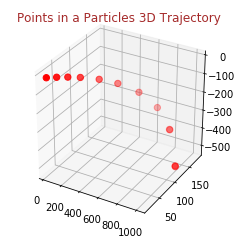

In [432]:
# Examining its point-wise trajectory...

Example_Trajectory = hitxyz[hitxyz.hit_id.isin(Example_Hits)]

x_val = np.array(list(Example_Trajectory['x']))
y_val = np.array(list(Example_Trajectory['y']))
z_val = np.array(list(Example_Trajectory['z']))

fig = plt.figure(figsize=(3, 3))
ax = Axes3D(fig)
ax.scatter(x, y, z, s=40, color='red', marker='o')
ax.set_title('Points in a Particles 3D Trajectory', color='brown')

plt.show()

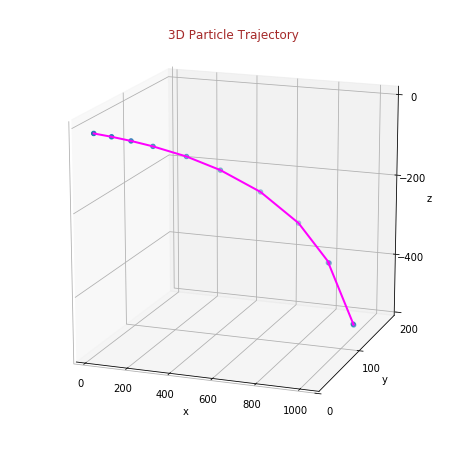

In [435]:
# The particle trajectory without using seaborn (which was being very uncooperative):

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(Example_Trajectory.x, Example_Trajectory.y, \
          Example_Trajectory.z, color='magenta', lw=2)
ax.scatter3D(Example_Trajectory.x, Example_Trajectory.y, \
          Example_Trajectory.z, cmap='blue')
ax.view_init(elev=16, azim=-70)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_yticks([0, 100, 200])
ax.set_zticks([-400, -200, 0])
ax.set_title('3D Particle Trajectory', color='brown')
    
plt.show()

In [263]:
# So this is what a reconstructed particle track should look like.  The shape of the path is close
# to helical, which is expected for charged particles travelling in an external magnetic field.  This
# domain knowledge will help to inform the models that we develop.

# This trajectory seems very simple when viewed by itself.  To better understand the challenge involved,
# one should examine the highlighted particle track in a more realistic environment:

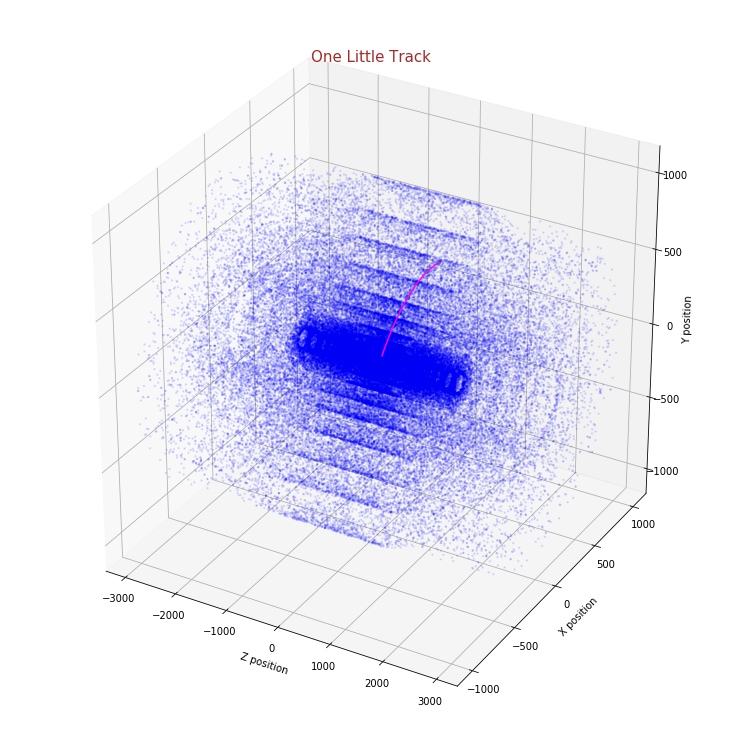

In [434]:
hitxyz = data.drop(['volume_id', 'layer_id', 'module_id'], axis=1)

x_coords = np.array(list(hitxyz['x']))
y_coords = np.array(list(hitxyz['y']))
z_coords = np.array(list(hitxyz['z']))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(z_coords, x_coords, y_coords, s=2, color='blue', alpha=0.09)

ax.plot3D(Example_Trajectory.z, Example_Trajectory.x, \
          Example_Trajectory.y, color='magenta', lw=1.5)
ax.scatter3D(Example_Trajectory.z, Example_Trajectory.x, \
          Example_Trajectory.y, cmap='purple')

ax.set_title('One Little Track', fontsize='15', color='brown')
ax.set_xlabel('Z position')
ax.set_ylabel('X position')
ax.set_zlabel('Y position')

plt.show()

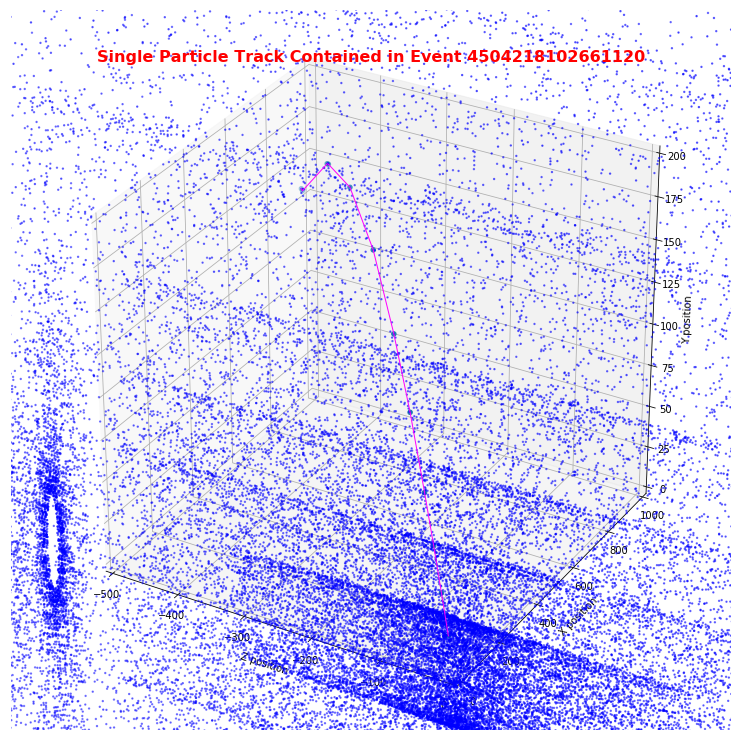

In [421]:
# Zooming in...

hitxyz = data.drop(['volume_id', 'layer_id', 'module_id'], axis=1)

x_coords = np.array(list(hitxyz['x']))
y_coords = np.array(list(hitxyz['y']))
z_coords = np.array(list(hitxyz['z']))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(z_coords, x_coords, y_coords, s=2, color='blue')

ax.plot3D(Example_Trajectory.z, Example_Trajectory.x, \
          Example_Trajectory.y, color='magenta', lw=1)
ax.scatter3D(Example_Trajectory.z, Example_Trajectory.x, \
          Example_Trajectory.y, cmap='purple')

ax.set_title('Single Particle Track Contained in Event 4504218102661120', color='red', weight='bold', fontsize='16')
ax.set_xlabel('Z position')
ax.set_ylabel('X position')
ax.set_zlabel('Y position')

ax.set_xlim(-500, 0)
ax.set_ylim(0, 1000)
ax.set_zlim(0, 200)

plt.show()

In [ ]:
#############################################################################################
#######################                  Notes                           ####################
#############################################################################################

# Still need to add summary plots that describe entire data set with odd-balls and
# possible errors noted.

# Switch cross section with 3D Event View.  Consider trasferring k-means analysis into this notebook
# (since mentioned and quick), but only if able to add in discussion of scoring before.  